# "Folio 01: Clustering"
> "[ML 1/3] Use Gaussian Mixture Model for Data Clustering"

- toc: true
- branch: master
- badges: true
- image: images/ipynb/folio_cluster.png
- comments: false
- author: Giaco Stantino
- categories: [portfolio project, machine learning]
- hide: false
- search_exclude: true
- permalink: /blog/folio-clustering

# <center>Intro</center>

This is the first of three machine learning alogrithms focused notebook in the Folio series. At the same this blog post is a part of my portFolio project, check out its [repository](https://github.com/giastantino/PortfolioProject).<br> Okay, let's get to the blog-post itself! Let me start with our task for today and broader perspective with a use case aswell.

***

**Task:** Cluster existing clients and propose marketing segments.

**Project use case:** Contract recommendation system supporting a company employee who presents an offer to a new client. 

The purpose of the classification task for the portfolio project is to predict new client's segment. The predicition is done with ML model based on clients' demographic data, which client provides during first interview, eg. age or education level. It turned out to be a hard problem to solve, because the segments were created in *Clustering notebook* using only clients' behaviour statistics, such as months on book or transactions count change. 

At the end of the notebook, out of over 8,000 customers, we selected four customer segments whose characteristics differ significantly: from card utilization, through the number of transactions, to openness to new products.

| card master | bill payer | golden fish | barrel scraper |
|:---:|:---:|:---:|:---:|
|  <img src="\images\ipynb\barrel_scraper.png" width="200" height="100"> |  <img src="\images\ipynb\bill_payer.png" width="200" height="100"> |  <img src="\images\ipynb\golden_fish.png" width="200" height="100"> |  <img src="\images\ipynb\barrel_scraper.png" width="200" height="100"> |


***





Import necessary libraries and download the data.

In [1]:
#collapse-hide

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import visualbox as vs

In [2]:
#collapse-hide

def getDataRepo(data='demographics'):
    """
    returns specified data from Repository as DataFrame
    Parameters:
    path - ['demographics', 'statistics' or 'segments']; default: 'demographics'
    """
    try:
        url = 'https://github.com/giastantino/PortfolioProject/blob/main/Notebooks/Data/' + data + '.csv?raw=True'
        client_df = pd.read_csv(url)
        print(data + ' data has been read')
        return client_df
    except Exception as e:
        print(e)
        
client_df = getDataRepo('statistics')

statistics data has been read


# <center>Data Exploration</center>

In this section we will do some basic data exploration.

In [3]:
#hide_input

#show first 5 rows
client_df.set_index(['client_id']).head(5)

attrition_flag  months_on_book  products_num_held_by_client  \
client_id                                                                   
708082083  Existing Customer              36                            4   
708083283  Attrited Customer              45                            3   
708084558  Attrited Customer              38                            6   
708085458  Existing Customer              24                            6   
708086958  Existing Customer              41                            3   

           inactive_months_in_last_year  contacts_in_last_year  \
client_id                                                        
708082083                             3                      3   
708083283                             1                      3   
708084558                             3                      3   
708085458                             2                      2   
708086958                             5                      2   

           average_open_to_buy_credit_line  \
client_id                                    
708082083                           1883.0   
708083283                            904.0   
708084558                           6487.0   
708085458                           1438.3   
708086958                           2379.0   

           total_transaction_amount_change_q4_q1  \
client_id                                          
708082083                                  0.831   
708083283                                  0.992   
708084558                                  0.000   
708085458                                  0.827   
708086958                                  0.598   

           total_transaction_amount_last_year  \
client_id                                       
708082083                             15149.0   
708083283                               992.0   
708084558                              1447.0   
708085458                              3940.0   
708086958                              4369.0   

           total_transaction_count_last_year  \
client_id                                      
708082083                                111   
708083283                                 21   
708084558                                 23   
708085458                                 82   
708086958                                 59   

           total_trasaction_count_change_q4_q1  average_card_utilazation_ratio  
client_id                                                                       
708082083                                    1                           0.469  
708083283                                    0                           0.736  
708084558                                    0                           0.214  
708085458                                    1                           0.000  
708086958                                    1                           0.239

In the data set there are 10 numerical features that describe clients. 

In [4]:
#hide_input

#statistical decription of dataset
client_df.drop(['client_id'],axis=1).describe().T

count         mean          std  \
months_on_book                         10127.0    35.928409     7.986416   
products_num_held_by_client            10127.0     3.812580     1.554408   
inactive_months_in_last_year           10127.0     2.341167     1.010622   
contacts_in_last_year                  10127.0     2.455317     1.106225   
average_open_to_buy_credit_line        10127.0  7469.139637  9090.685324   
total_transaction_amount_change_q4_q1  10127.0     0.759941     0.219207   
total_transaction_amount_last_year     10127.0  4404.086304  3397.129254   
total_transaction_count_last_year      10127.0    64.858695    23.472570   
total_trasaction_count_change_q4_q1    10127.0     0.875185     0.365702   
average_card_utilazation_ratio         10127.0     0.274894     0.275691   

                                         min       25%       50%       75%  \
months_on_book                          13.0    31.000    36.000    40.000   
products_num_held_by_client              1.0     3.000     4.000     5.000   
inactive_months_in_last_year             0.0     2.000     2.000     3.000   
contacts_in_last_year                    0.0     2.000     2.000     3.000   
average_open_to_buy_credit_line          3.0  1324.500  3474.000  9859.000   
total_transaction_amount_change_q4_q1    0.0     0.631     0.736     0.859   
total_transaction_amount_last_year     510.0  2155.500  3899.000  4741.000   
total_transaction_count_last_year       10.0    45.000    67.000    81.000   
total_trasaction_count_change_q4_q1      0.0     1.000     1.000     1.000   
average_card_utilazation_ratio           0.0     0.023     0.176     0.503   

                                             max  
months_on_book                            56.000  
products_num_held_by_client                6.000  
inactive_months_in_last_year               6.000  
contacts_in_last_year                      6.000  
average_open_to_buy_credit_line        34516.000  
total_transaction_amount_change_q4_q1      3.397  
total_transaction_amount_last_year     18484.000  
total_transaction_count_last_year        139.000  
total_trasaction_count_change_q4_q1        4.000  
average_card_utilazation_ratio             0.999

We can see that most of the clients made 2 to 3 contacts in last year, they hold 3 to 5 products. The mean of total transacation amount change is 0.76, also mean transaction suffered a drop - 0.875 quater to quater. 

***

There is also one categorical feature that determines whether the client is an existing customer or attrited.

In [5]:
#collapse-hide

#print categorical values defining every column
def print_unique_values(df):
  for col in df.select_dtypes(include=['object']).columns:
    print(f'-> {col}({len(df[col].unique())}):')
    print(f'{df[col].value_counts()}\n'),

print_unique_values(client_df)

-> attrition_flag(2):
Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64



There is 8500 existing clients in the dataset.

***

## Sample clients

To get better understanding of the clients, let's select a few data points (that are different from each other) and explore them.

In [6]:
#collapse-hide

# select from active clients
adf = client_df.drop(client_df[client_df['attrition_flag']=='Attrited Customer'].index).drop(['attrition_flag','client_id'], axis='columns').reset_index(drop=True)

# selecting three indicises
indices = [3, 300, 2000]

# create a DataFrame of the chosen samples
samples = pd.DataFrame(adf.loc[indices], columns = adf.keys()).reset_index(drop=True)
print ("Chosen client samples:")
display(samples)

Chosen client samples:


months_on_book  products_num_held_by_client  inactive_months_in_last_year  \
0              34                            5                             2   
1              34                            2                             3   
2              36                            6                             1   

   contacts_in_last_year  average_open_to_buy_credit_line  \
0                      2                          31471.0   
1                      3                          11343.0   
2                      3                          10008.0   

   total_transaction_amount_change_q4_q1  total_transaction_amount_last_year  \
0                                  0.428                              1448.0   
1                                  0.709                              8027.0   
2                                  0.664                              3730.0   

   total_transaction_count_last_year  total_trasaction_count_change_q4_q1  \
0                                 29                                    0   
1                                 94                                    1   
2                                 67                                    1   

   average_card_utilazation_ratio  
0                           0.055  
1                           0.000  
2                           0.132

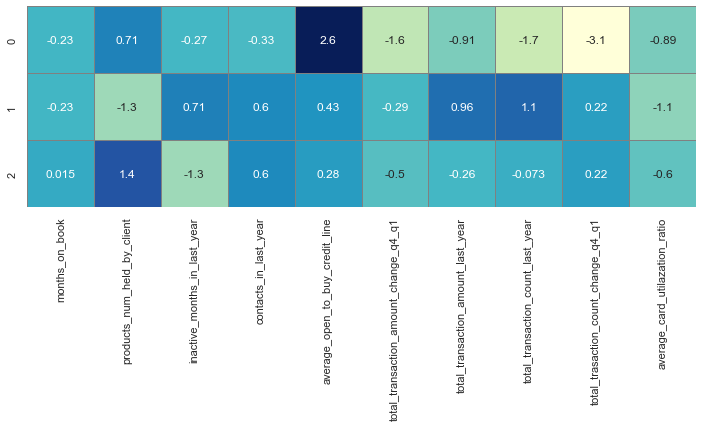

In [7]:
#collapse-hide

#plot heatmap
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap((samples-adf.mean())/adf.std(ddof=0), 
            annot=True, 
            cbar=False, 
            square=True,
            cmap = plt.cm.YlGnBu,
            linewidths=0.7,
            linecolor="grey");

Three sample clients differ a lot:
* sample 0 - client that is interested in buying new credit line, but the number of transactions q4-q1 change negatively - fleeing customer?
* sample 1 - client who holds low number of products but the trasaction rate is positive, contacts the bank frequently and is open to buy new credit lane - promising customer
* sample 2 - client with many months on book who holds a lot of products, held frequent contacts, but the number of transactions has dropped and is less open to buy credit line that sample 1 - possibly fleeing customer in near future

# <center>Data transformation</center>

To begin with, we will delete not-exisiting clients as they add unnecessery noise. Then, we are going to deal with outliers, which may distort the clusters. Lastly we will transform the data, because machine learning algorithms tend to deal better with transformed numerical data. For instance, mean of months_on_book is 36 and mean average_open_to_buy_credit_line is 7469, but it doesn't make the feature more important, although it's obvious to human reader, ML algorithm may struggle with weighting those data point if we don't normalize/standardize them.

## Delete attrited customers

Let's deal with customers that were marked with attrition flag as they are inactive. 

In [8]:
#collapse-hide

#drop attrited customers
active_df = client_df.drop(client_df[client_df['attrition_flag']=='Attrited Customer'].index).reset_index(drop=True)

#attrtion_flag column
active_df = active_df.drop(['attrition_flag'], axis='columns')

#create dataframe holding client_id
client_id_df = pd.DataFrame(active_df['client_id'])
active_df = active_df.drop(['client_id'], axis='columns')

print(active_df.shape)

(8500, 10)


## Feature distributions

Let's construct a distribution matrix for each pair of numeric continuous features in the data to better understand the distribution of values across the data.


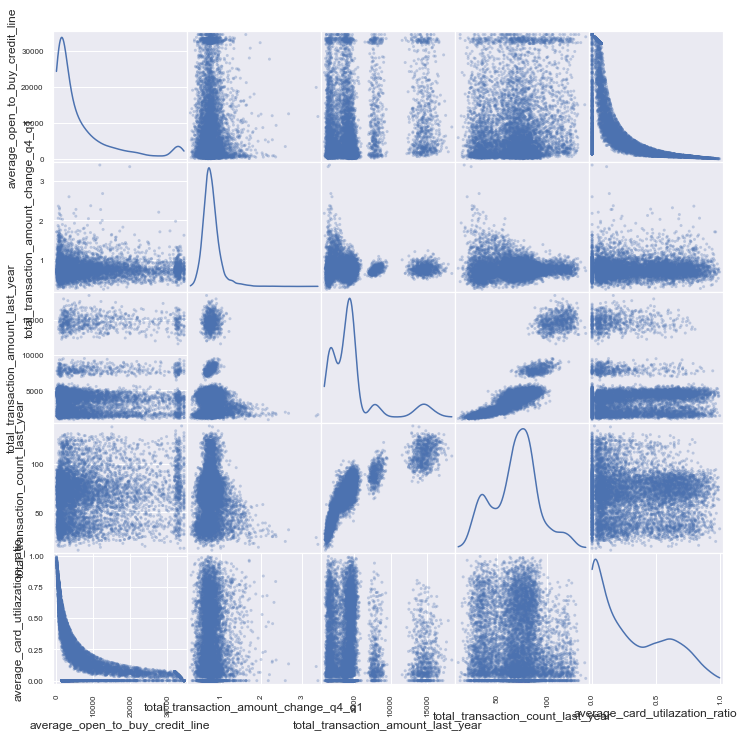

In [9]:
#collapse-hide

# scatter matrix for each pair of features
pd.plotting.scatter_matrix(active_df.drop(['months_on_book', 'products_num_held_by_client','inactive_months_in_last_year', 'contacts_in_last_year', 'total_trasaction_count_change_q4_q1'],axis=1), 
                           alpha=0.3, figsize=(12,12), diagonal='kde');

The data is very right scewed it may be appropiate to apply non-linear scaling. In order to reduce skeweness, let's use PowerTransformer from sklearn package, which uses yeo-johnson transform. 

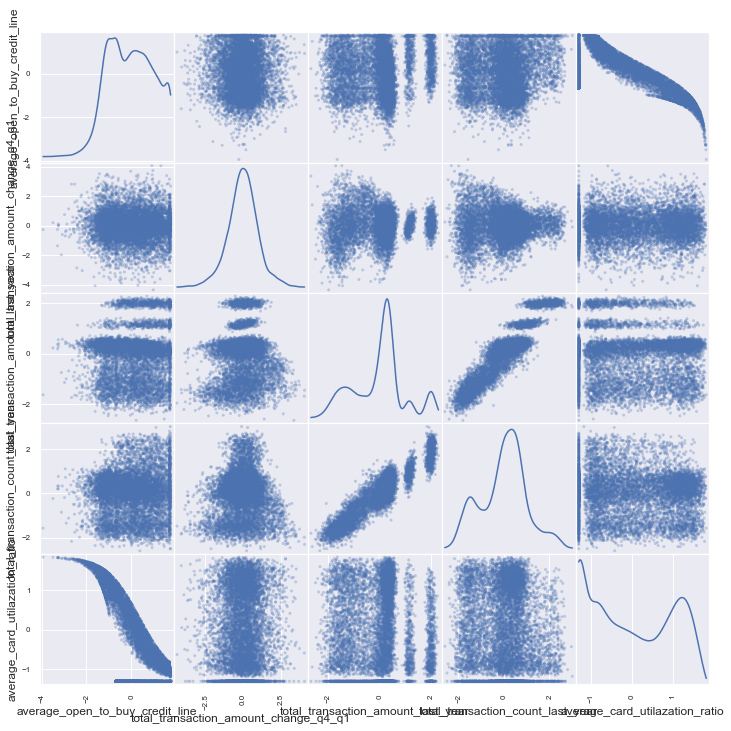

In [10]:
#collapse-hide

from sklearn.preprocessing import PowerTransformer

#create power transformer object
ptr = PowerTransformer()

#transform the data
trans_df = pd.DataFrame(ptr.fit_transform(active_df), columns=active_df.columns)

# plot transformed data
pd.plotting.scatter_matrix(trans_df.drop(['months_on_book', 'products_num_held_by_client','inactive_months_in_last_year', 'contacts_in_last_year', 'total_trasaction_count_change_q4_q1'],axis=1), 
                           alpha=0.3, figsize=(12,12), diagonal='kde');

After aplying power transformer to the data, the distribution of most features looks much more gaussian-like, which is desirable for a Gaussain Mixture Model.

> Tip: Guassian Mixture Model tends to work best for data with a near-normal distribution

***

## Outlier detection

Dealing with outliers is an important step within data preprocessing. The presence of outliers can ofter distort the results that take into consideration these data points. Here I'm going to use Tukey's Method: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [11]:
#collapse-show

from collections import Counter

def tukeys_method(df):
    """
    takes in DataFrame, from wich it selects outlier indices using tukey's method
    Returns: outliers indexes
    Parameter
    df - original dataframe
    """
    # For each feature find the data points with extreme high or low values
    outliers = []
    for feature in df.keys():

        # Calculate Q1 (25th percentile of the data)
        Q1 = np.percentile(df[feature], 25)

        # Calculate Q3 
        Q3 = np.percentile(df[feature], 75)

        #  calculate an outlier step
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        #print(f"Data points considered outliers for the feature {feature}:")
        #display(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))])
        
        #update outliers list
        outliers = outliers + df[~((trans_df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.tolist()

    # Select the indices for data points to remove
    cntr = Counter(outliers)
    for i in cntr.keys():
        if cntr[i] > 0:
            outliers.remove(i)
    outliers = set(outliers)
    return list(outliers)

# Define outliers
outliers = tukeys_method(trans_df)

# Remove the outliers
good_data = trans_df.drop(trans_df.index[outliers])

print(str(len(outliers)) + "\nOutliers have the following indices : ")
print(outliers)

277
Outliers have the following indices : 
[513, 4, 5636, 8198, 5639, 6665, 2062, 2063, 4112, 5647, 7701, 4630, 537, 2074, 3610, 2592, 1569, 2083, 4645, 2087, 8231, 6698, 6187, 7212, 45, 1070, 6420, 2099, 4660, 8244, 7222, 1084, 2624, 2627, 3652, 4169, 4174, 7246, 4181, 6743, 4696, 1627, 7772, 4191, 1121, 6532, 7266, 8292, 7269, 3692, 8301, 620, 6769, 2162, 2679, 6263, 1143, 1149, 2686, 6782, 7299, 4606, 7818, 2188, 3216, 6291, 6804, 1683, 3220, 4248, 7836, 8349, 2718, 6815, 1184, 2208, 3231, 1190, 8360, 1192, 3757, 5294, 686, 3253, 4791, 4793, 4285, 5309, 709, 5830, 2763, 7887, 3795, 212, 5331, 6870, 7893, 1242, 2779, 6878, 7390, 7902, 5346, 3811, 7908, 6373, 4325, 4328, 233, 5353, 236, 749, 3308, 4847, 1265, 7410, 758, 1786, 6907, 6396, 2815, 6911, 1792, 6402, 3843, 5892, 6917, 7939, 2311, 5895, 8452, 4362, 3852, 2829, 4879, 272, 5906, 4372, 5397, 1300, 5911, 792, 7961, 282, 1307, 3354, 3866, 4890, 4895, 5411, 2852, 7973, 4904, 7466, 2859, 6956, 7982, 2863, 307, 3379, 5430, 3385, 748

    277 outliers have been removed as they disturb the mean and std deviation of transformed dataset.
    
***

## Principal component analysis

In this subsection, we use PCA to draw conclusions about a underlying data structure as PCA computes the dimensions that best maximize variance. A side effect of this process is a reduction in dimensionality, which can also make it easier for the model to identify clusters.

We need to choose the number of dimensions, so let's first check how each pricniple component (dimension) explains variance of the data.

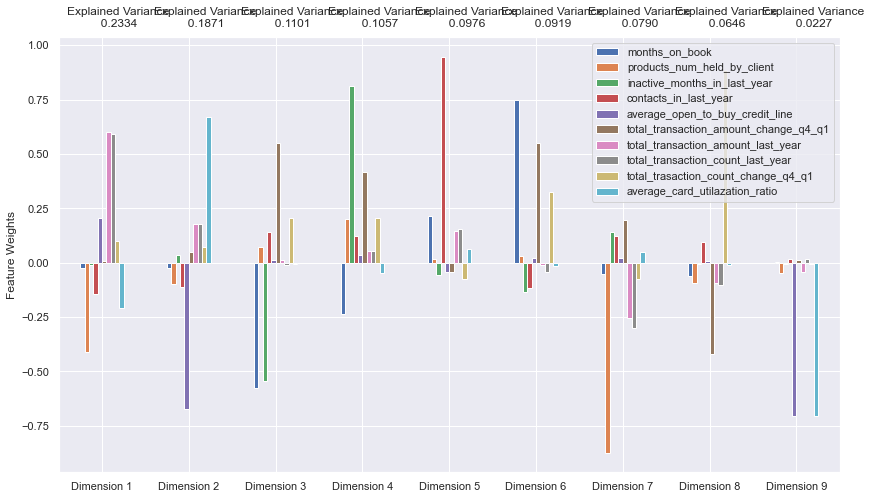

In [12]:
#collapse-hide

from sklearn.decomposition import PCA

# define PCA
pca = PCA(n_components='mle')
pca.fit(good_data)

# plot the data
pca_results = vs.pca_results(good_data,pca)

* The total variance explained by the first three components is 0.53, for the first fourth it is 0.635
* The first four components represent the following:
    * In the 1st component, the dominant features are `total_transaction_amount_last_year` and `total_transaction_count_last_year`
    * In the 2nd component, the dominant features are `average_card_utilization_ratio` and `average_open_to_buy_credit_line` (negatively correlated with each other)
    * In the 3rd component, the dominant features are `months_on_book` and `inactive_months_in_last_year`, which are negatively correlated to `total_transaction_amount_change_q4_q1`
    * In the 4th component, the dominant feature is `inactive_months_in_last_year`
* The first four dimensions capture a large amount of the variance of all features (except contatcs_in_last_year) of the original dataset.

### Dimensionality Reduction

When using PCA, one of the main goals is to reduce the dimensionality of the data - in effect, reducing the complexity of the problem. It comes at a cost, fewer dimensions = less of the total variance. Therefore culmulative explained variance ratio is extremely important (as ploted below).

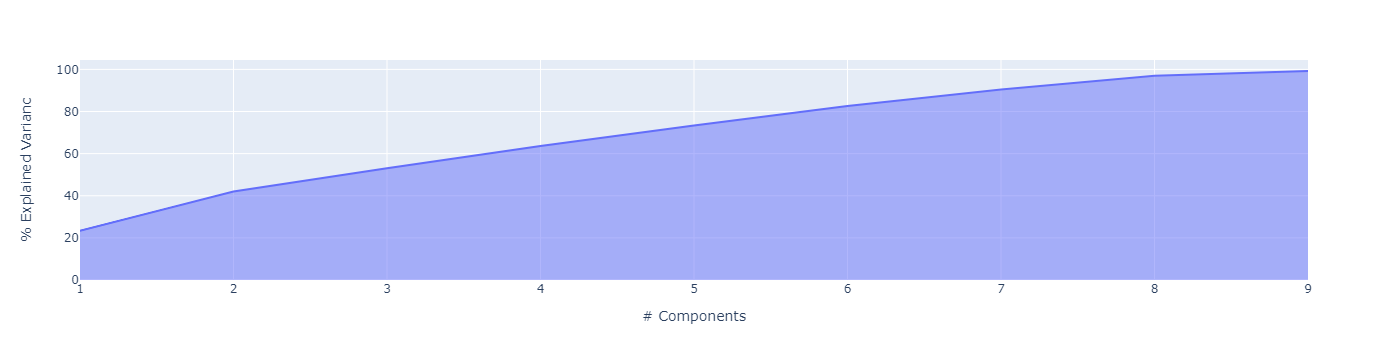

In [13]:
#collapse-hide
#hide_output
import plotly.express as px

# plot the culmulative variance ratio
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

area_fig = px.area(x=range(1, exp_var_cumul.shape[0] + 1),
                   y=exp_var_cumul*100,
                   labels={"x": "# Components", "y": "% Explained Varianc"},
                   width = 720, height=360,
                  )

area_fig.show()

In [14]:
#hide_input
HTML(area_fig.to_html(include_plotlyjs='cdn', include_mathjax=False))

The first four components account for 63.6% of the variance in the dataset, but the first five components improve this score by 10 percentage points. 
    
For this project it was decided to use 5 components.

In [15]:
# create pca with 5 dims
pca = PCA(n_components = 5)

# transform the data
reduced_data = pca.fit_transform(good_data)

reduced_data = pd.DataFrame(reduced_data, columns=['Dim1','Dim2','Dim3','Dim4','Dim5'])

### Visualization of reduced dimensions

We can now plot the data on a series of 2D scatter plots where the axes are the selected principal components.

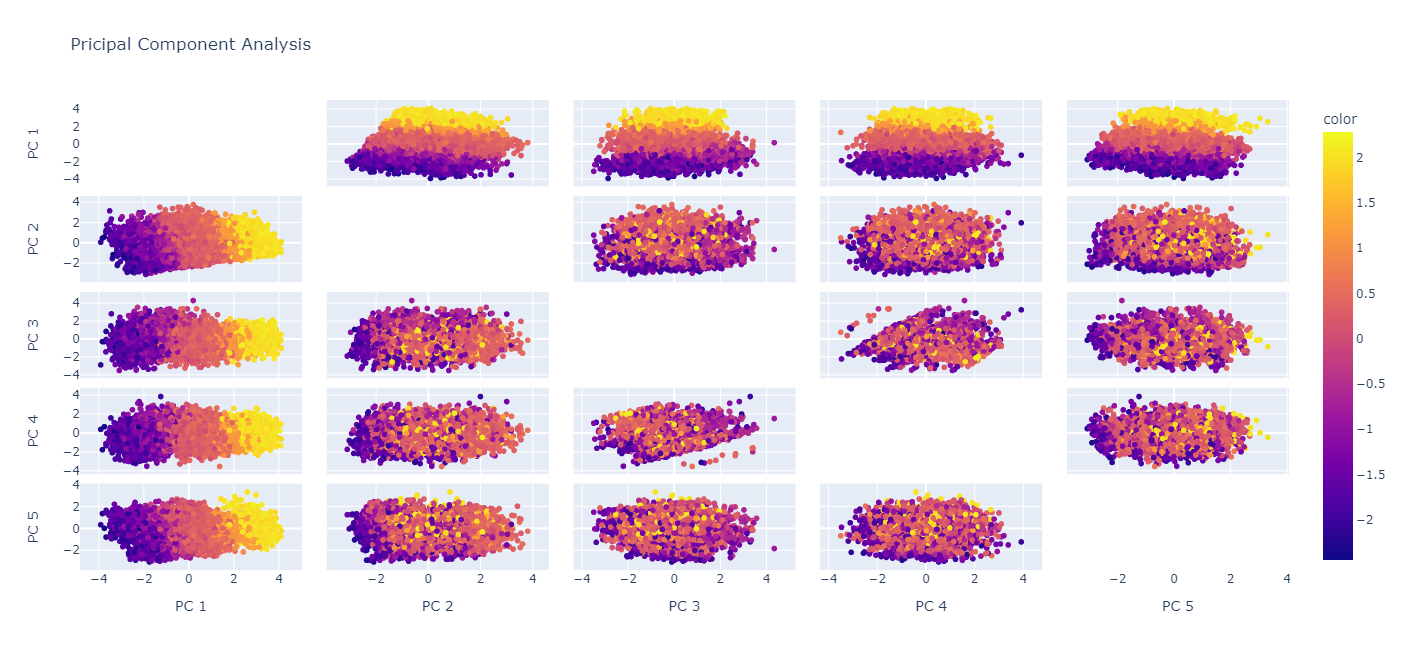

In [16]:
#collapse-hide
#hide_output
# create lables
labels = {
    str(i): f"PC {i+1}" #({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

# plot figure
fig = px.scatter_matrix(
    reduced_data.to_numpy(),
    labels=labels,
    dimensions=range(5),
    width = 650, height = 650,
    color=good_data['total_transaction_amount_last_year'],
    title='Pricipal Component Analysis'
)

fig.update_traces(diagonal_visible=False)
fig.show()

In [17]:
#hide_input
HTML(fig.to_html(include_plotlyjs='cdn', include_mathjax=False))

Above the data points are colored based on their transformed `total_transaction_amount_last_year` value. In the previously plotted graph, PC1 explained variance of this feature very well. Here we can see that in fact the PCA did a good job of separating the points at least for the first component of PC1. That is very promising for the clustering algorithm.

# <center>Clustering</center> 

In this paragraph, the data points will be grouped into clusters. Clients will be split using the Gaussian Mixture algorithm, but the number of clusters must be determined first.

When it comes to creating clusters we first need know the number of clusters we expect. Unfortunately we don't know the number a priori, we need to predict it based on the structure that exists in data. In other words, we need a way of quantifing the "goodness"of predicted cluster.

## Number of Clusters

One can think of gaussian mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data. Therefore, we can try two approaches to determining the number of clusters: 
1. Elbow method - it is the most common approach for the k-means clustering method. 
2. Bayesian Information Criterion (BIC)

### Elbow method

It involves running the algorithm in a loop multiple times, with an increasing number of clusters and then plotting a distortion (sum of squared distances of samples to their closest cluster center) as a function of the number of clusters.

Then we choose the number of clusters for which choosing a higher number does not significantly lower the result.

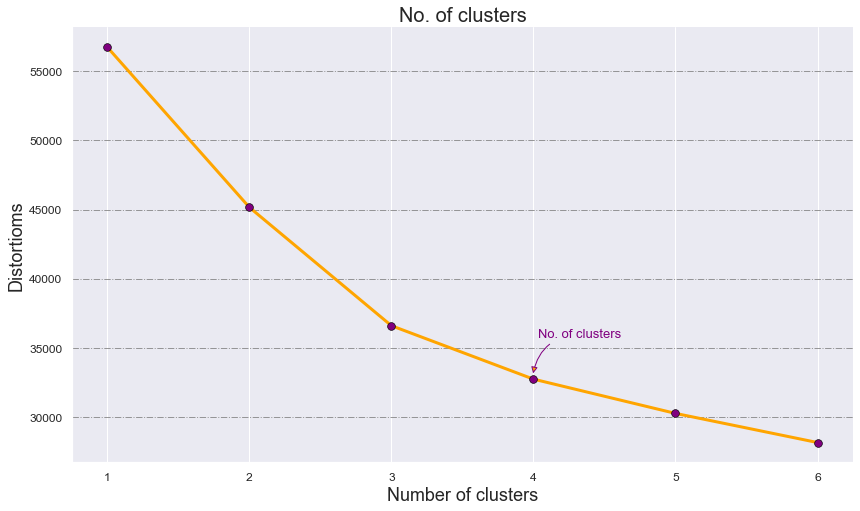

In [18]:
#collapse-hide
from sklearn.cluster import KMeans

def elbow_method(df):
    distortions = []
    K = range(1,7)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
  
    def draw_elbow():
        
        #plot the elbow method
        fig, ax = plt.subplots(figsize = (14, 8))
        plt.title('No. of clusters', size = 20)
        plt.grid(color = 'gray', linestyle = '-.', axis = 'y', alpha = 0.8, zorder = 0,)  
        plt.plot(K, distortions, color = 'orange', linewidth = 3)
        sns.scatterplot(x = K, y = distortions, color = 'purple', s = 60, edgecolor = 'black', zorder = 5)
        plt.ylabel('Distortioms', size = 18)
        plt.xlabel('Number of clusters', size = 18)
        plt.xticks(size = 12)
        plt.yticks(size = 12)
        
        # define annotation
        plt.annotate('No. of clusters', 
                 xy = (.59, .20), xycoords='axes fraction',
                 xytext = (.65, .28), textcoords='axes fraction',
                 fontsize = 13, ha = 'center', va = 'bottom', color = 'purple',
                 arrowprops = dict(arrowstyle = "-|>", connectionstyle = "arc3,rad = 0.4", 
                                   fc = 'orange', ec = 'purple'), 
                 )
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom']
        ax.spines['left']
  
    draw_elbow()
elbow_method(reduced_data)

In our case, the number chosen from the elbow method is **4 clusters**.

### Bayesian Information Criterion

Sometimes, when using Bayesian Mixture, BIC is a more reliable method. In theory, extremely complex clusters of data can also be modeled as a superimposition of a large number of Gaussian datasets. There is no restriction on how many Gaussians to use for this purpose. The BIC method penalizes a large number of Gaussians and tries to keep the model simple enough to explain the given data pattern.

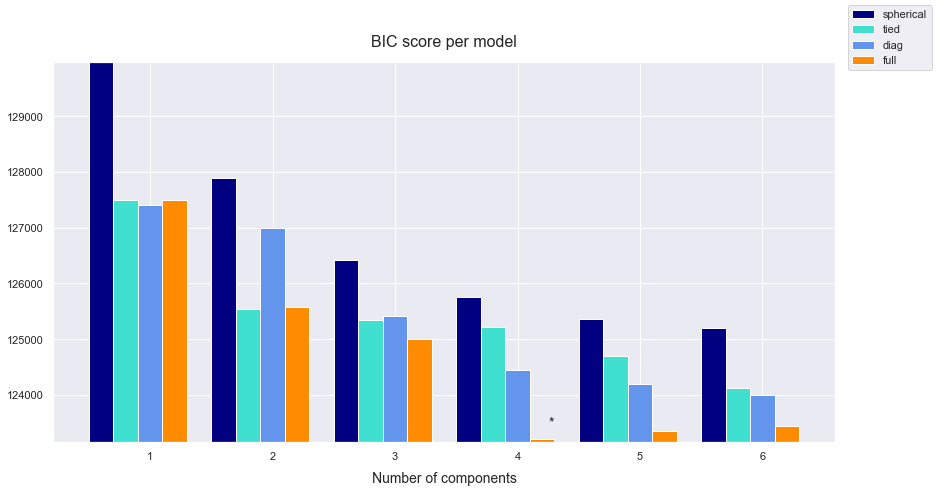

In [19]:
#collapse-hide

from sklearn import mixture
import itertools

def bic_method(X):
    
    lowest_bic = np.infty
    bic = []

    n_components_range = range(1, 7)

    # define covariance list
    cv_types = ["spherical", "tied", "diag", "full"]

    # get the bic values
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(
                n_components=n_components, covariance_type=cv_type, random_state=42
            )
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)

    color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])

    #define algorithm
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    fig = plt.figure(figsize=(14, 7))
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            plt.bar(
                xpos,
                bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
                width=0.2,
                color=color,
            )
        )
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
    plt.title("BIC score per model", fontsize=16, pad=15)
    plt.xlabel("Number of components", fontsize=14, labelpad=10)

    xpos = (
        np.mod(bic.argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(bic.argmin() / len(n_components_range))
    )
    plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)

    fig.legend([b[0] for b in bars], cv_types, loc='upper right')
    
bic_method(reduced_data)

Above graph of model selection concerns both the [covariance type](https://scikit-learn.org/stable/modules/mixture.html#gmm) and the number of components in the model.

The BIC results further convinces us that the number of clusters should be **4**. Moreover, it suggests using **full covariance** for our GMM model!

## Gaussain Mixture Model


A [Gaussian mixture model](https://scikit-learn.org/stable/modules/mixture.html) is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 

We are using the GMM algorithm to create 4 clusters with full covariance type.

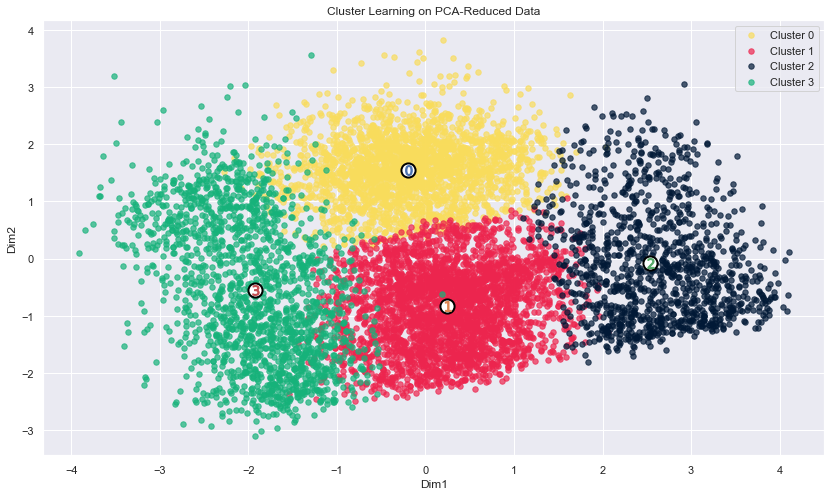

In [20]:
#collapse-show
from sklearn.mixture import GaussianMixture

# define algorithm
clusterer = GaussianMixture(n_components = 4, covariance_type = 'full', init_params='kmeans', random_state = 2137)

# Predict the cluster for each data point
preds = clusterer.fit_predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers)

The above graph shows the data points fitted into 4 clusters plotted on two dimensional graph PC2(PC1). 

Having created the clusters, we will try to describe them in the context of data and determine if they meet our expectations.

In [21]:
#collapse-hide

#create dataframe for clustered_data
clusters_df = active_df.drop(outliers)
clusters_df['segment'] = preds

# <center>Segments</center>

With clusters created and clients assigned to segment we will have a first look at created groups. 
* Firstly, we will try to draw some conclusion based on the polar graph of average client in the cluster  
* Then plot the percentages of the segments in the data
* Lastly, to check if the cluster are of any representative value we will draw the candle and violing graphs of every category in each segment

***

In [22]:
#collapse-hide
#hide_output
# average client of each segment vs average values of all the data
segments_info = np.round((clusters_df.groupby(['segment']).mean())/active_df.mean(),3).reset_index()

# data preparation
polar=pd.melt(segments_info, id_vars=['segment'])

# draw the polar graph
fig2 = px.line_polar(polar, r="value", theta="variable", color='segment',
                     color_discrete_map={1:'#ED254E',0:'#F9DC5C',3:'#16b27a',2:'#011936'},
                     line_close=True, height=600, width=800)

#fig2.show()

In [23]:
#hide_input
HTML(fig2.to_html(include_plotlyjs='cdn', include_mathjax=False))

Looking at the polar chart we can see that:

* segments do not differ much from each other when it comes to months_on_book and total_transaction_amount_change
* segment 0 is defined by higer then average card utilization and very low oppenes to new credit lines
* segment 1 is defined by a little higher then average openness to but credit line, lower_card_utilzation_ratio
* segment 2 is defined by high total_transacation_amount_last_year, total_transacation_count_last_year and average_open_to_buy_credit_line, *but* lower than average products_num_held_by_client and average_card_utilization_ratio
* segment 3 is defined by lower then average transaction_count_last_year and total_transaction_amount_last_year

Let's name created segments:
    
* segment 0 - **card_master** - represents clients who tend to utilize their card a lot, but are not interested in opening new lines and contact the bank less often than average
    
* segment 1 - **bill_payer** - represents clients who are quite open to but new credit line, but aren't utilizng their card, the transaction amount is close to average  

* segment 2 - **golden_fish** - represent clients who are higher than average when in to comes to total transacion amount and count, they are really open to buy new credit line yet don't hold a lot of products and rarely contact the bank 
    
* segment 3 - **barrel_scraper** - represents clients who do not make too many transactions, moreover, the number of transactions drops from the fourth quarter to the first, but they have more products than the average customer and their use of a card, openness to contact and purchase of a new line of credit are average 
  


***

In [24]:
#collapse-hide
# rename the segments
def rename_segments(str):
    if str == 0: return 'card_master'
    elif str == 1: return 'bill_payer'
    elif str == 2: return 'golden_fish'
    else: return 'barrel_scraper'
    
# apply renaming function    
clusters_df.segment = clusters_df.segment.apply(rename_segments)

In [25]:
#collapse-hide
# get the cluster data
clust_es = clusters_df.segment.value_counts()
labels = clust_es.index.to_list()
values = clust_es.values

Let's draw pie chart and check segments representation

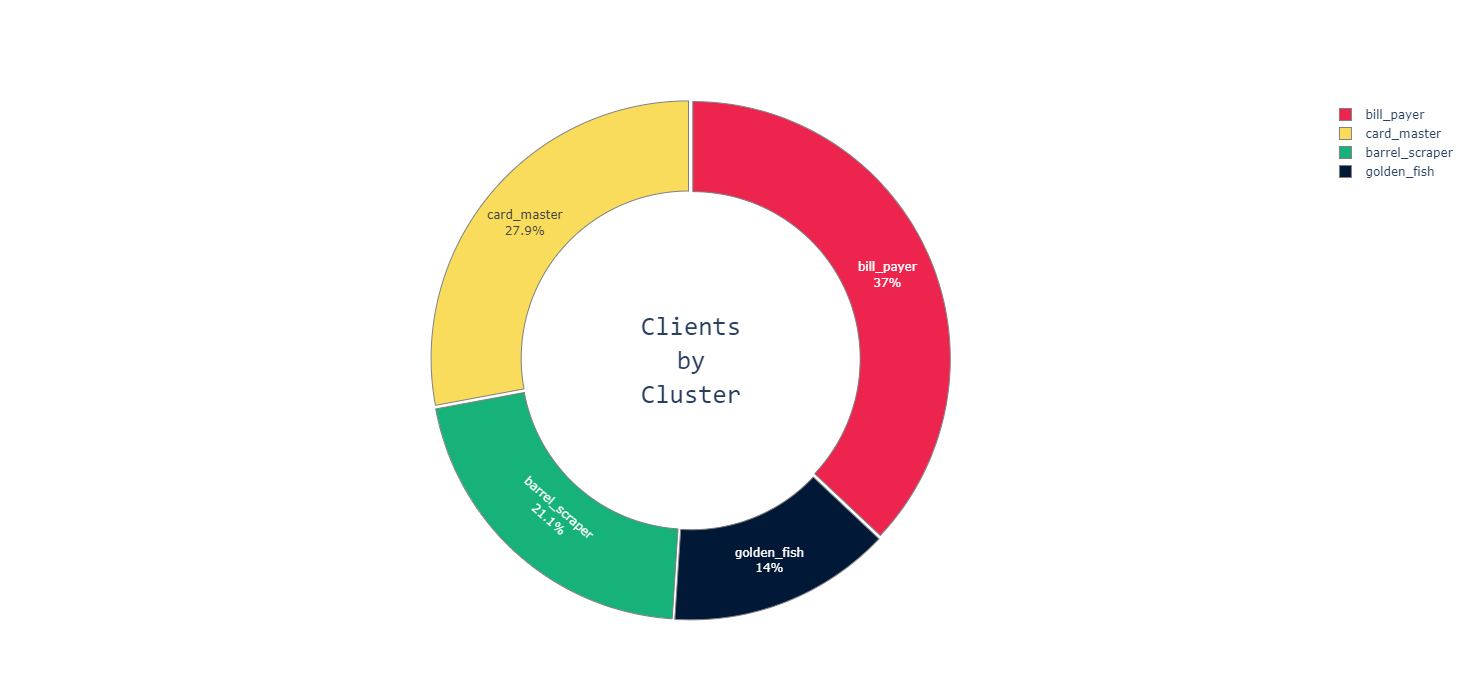

In [26]:
#collapse-hide
#hide_output
# color theme
colors = ['#ED254E','#F9DC5C', '#16b27a', '#011936']

# draw pie chart
fig = go.Figure()
fig.add_trace(go.Pie(labels=labels, 
                     values=values,
                     name='Clusters',
                     pull=[0.01, 0.01, 0.01, 0.01] 
                     ))
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label',
                  hole = 0.65, 
                  marker = dict(colors = colors,
                                line = dict(color = 'gray', width = 1)),
                  hovertemplate = 'Clients: %{value}',
                  )
fig.update_layout(title_text="",
                  autosize=False,width=700,height=700,
                  annotations=[dict(text='Clients<br>by<br>Cluster', 
                                    x=0.5, y=0.5, 
                                    font_size=26, 
                                    font_family = 'monospace',
                                    showarrow=False),
                               ]
                  )
#fig.show()

In [27]:
#hide_input
HTML(fig.to_html(include_plotlyjs='cdn', include_mathjax=False))

As we can see above most of clients are `bill_payers` - 37%. The `card_masters` and `barrel_scrapers` account for 27.9% and 21.1% repsectively. The least represented group is `golden_fish` - 14%.

***

## Segments feature analysis

Let's plot the two features that make `card_master` and `golden_fish` segments the most distinct from the rest: `average_card_utilazation_ratio` and `total_transaction_amount_last_year`.

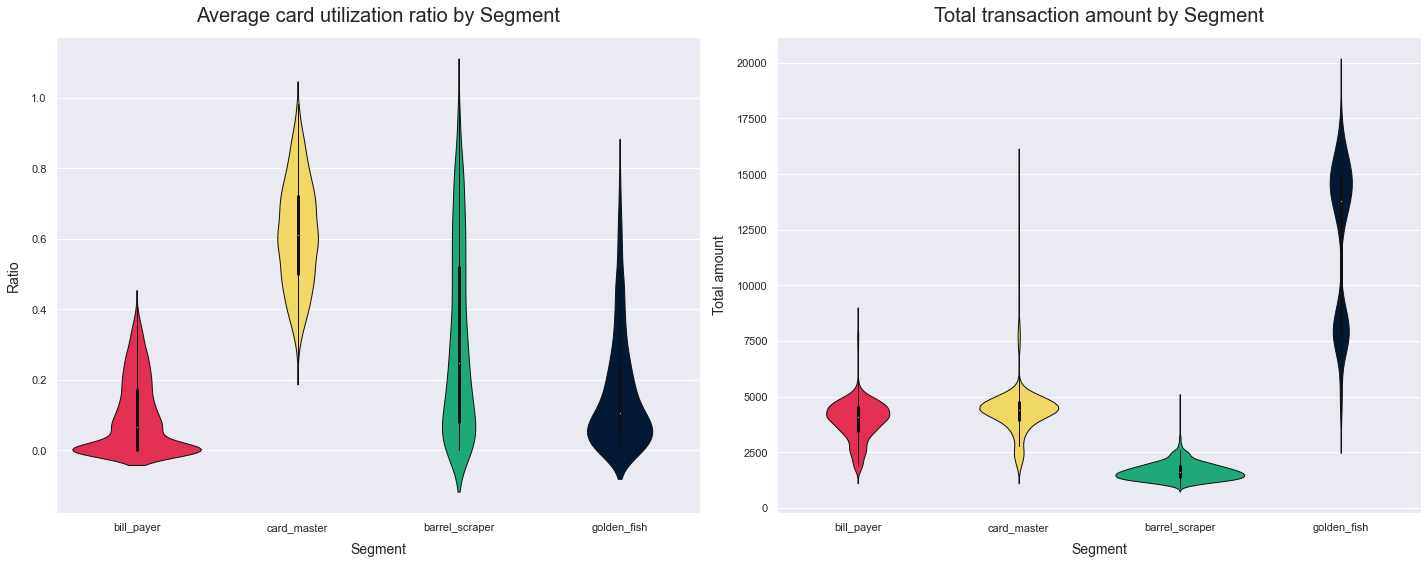

In [28]:
#collapse-hide

# setup sublots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))
#“box”, “quartile”, “point”, “stick”,
# plot the card utilization
card_fig = sns.violinplot(data=clusters_df, x='segment', y='average_card_utilazation_ratio', ax=ax1,
                          linewidth=1, saturation=.9,
                          order = ['bill_payer', 'card_master', 'barrel_scraper', 'golden_fish'],
                          palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'});

# setup card utilization plot
card_fig.set_xlabel('Segment', fontsize=14, labelpad=10)
card_fig.set_ylabel('Ratio', fontsize=14, labelpad=10)
card_fig.set_title('Average card utilization ratio by Segment', fontsize=20, pad=15)


# plot total transaction amount
amount_fig = sns.violinplot(data=clusters_df, x='segment', y='total_transaction_amount_last_year', ax=ax2,
                            linewidth=1, saturation=.9,
                            order = ['bill_payer', 'card_master', 'barrel_scraper', 'golden_fish'],
                            palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'});

# setup card utilization plot
amount_fig.set_xlabel('Segment', fontsize=14, labelpad=10)
amount_fig.set_ylabel('Total amount', fontsize=14, labelpad=10)
amount_fig.set_title('Total transaction amount by Segment', fontsize=20, pad=15)

fig.subplots_adjust(wspace=0.3);
fig.tight_layout();

As for the card utilization ratio, we can see that `card_master` segment has the highest utilzation distribution with a median over 0.6. The lowest ratio describes the groups `bill_payer` and `golden_fish`. Segment `barrel_scraper` is evenly distributed along the ratio, but most clients have utilization ratio between 0.1 and 0.5.

The total transaction amount chart shows the distribution of the total amount by client segment. We can see that `barrel_scraper` has lower total amount distribution than others. `Bill_payer` amd `card_master` distribution are comparable, with the latter having a slightly higher median and more outliers. The `golden_fish` segment has by far the highest median and mean of all the clusters. At same time, for this segment the distribution of total amount is hourglass-like. This can be interpreted as two smaller groups of clients that are part of the same cluster, but they do not differ enough to warrant a separate segment.

***

Let's have a look at two more features: `months_on_book` and `products_num_held_by_client` .

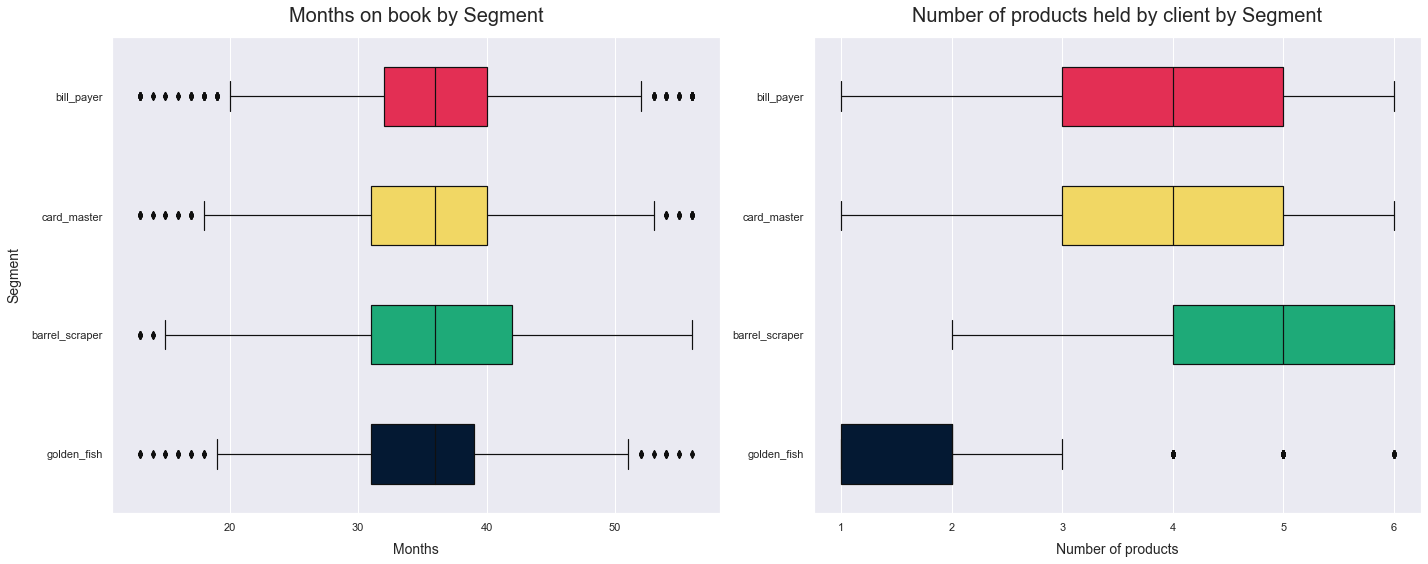

In [29]:
#collapse-hide

# setup sublots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

# plot the card utilization
months_fig = sns.boxplot(data=clusters_df, y='segment', x='months_on_book', ax=ax1,
                         linewidth=1.2, orient='h', saturation=0.9, width=0.5,
                         order = ['bill_payer', 'card_master', 'barrel_scraper', 'golden_fish'],
                         palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'});

# setup card utilization plot
months_fig.set_ylabel('Segment', fontsize=14, labelpad=10)
months_fig.set_xlabel('Months', fontsize=14, labelpad=10)
months_fig.set_title('Months on book by Segment', fontsize=20, pad=15)


# plot total transaction amount
prod_fig = sns.boxplot(data=clusters_df, y='segment', x='products_num_held_by_client', ax=ax2,
                          linewidth=1.2, orient='h', saturation=0.9, width=0.5,
                          order = ['bill_payer', 'card_master', 'barrel_scraper', 'golden_fish'],
                          palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'});

# setup card utilization plot
prod_fig.set_ylabel('')
prod_fig.set_xlabel('Number of products', fontsize=14, labelpad=10)
prod_fig.set_title('Number of products held by client by Segment', fontsize=20, pad=15)

fig.subplots_adjust(wspace=0.4);
fig.tight_layout();

In the above 'Months on book by Segment' chart we can clearly see that months on book are not descriptive at all, meaning we wouldn't be able do predict the segment of the data point based only on this feature. In the 'Number of products held by client by Segment' chart, there are presented distinct differences between segment `golden_fish` and `barrel_scraper` - first has most of the sample in range 1 to 2 for number of products and the latter in 4 to 5. On the hand, this feature doesn't provide any information that would make `bill_payer` and `card_master` segment distinguishable.

# <center>Summary</center>

The task of the notebook was to cluster existing clients and propose marketing segments. 

Firstly, the data was explored and attrited customers were deleted from dataset. Then it was transformed in order to make the features distributions gaussian-like, as it is desirable for our model. Outliers were detected and deleted. Next, principal component analysis was used to try to discover underlying stracture of the data and reduce the dimensionality of the dataset. 

The clustering algorithm need specified number of clusters to detect. The optimal number of cluster was chosen based on the elbow method and BIC values. Lastly Gausian Mixture Model created four clusters.

In the end, the clusters were described in the context of the original features and four marketing segments were proposed: `bill_payers`, `card_masters`, `barrel_scraper` and `golden_fish`. The model discovered distinguishable segments, that describe different client groups well in terms of the features of original dataset.
